In [78]:
# MNIST and Deep learning CNN
import torch
import torchvision.datasets as datasets # 이미지 관련 파이토치 라이브러리
import torchvision.transforms as transforms # 전처리 기능 제공하는 라이브러리
import torch.nn as nn # torch 내의 세부적인 기능 불러오기 (신경망 기술, 손실함수 등)
import torch.nn.functional as F # 신경망 기술
import torch.optim as optim # 최적화 문제
import matplotlib.pyplot as plt # 시각화 도구

In [79]:
# CPU/GPU
# GPU 쓰려구. CNN은 GPU에서 효율적인 연산 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [80]:
# parameters
learning_rate = 0.001
training_epochs = 5
batch_size = 100

In [81]:
# MNIST dataset
mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [82]:
# 일반적으로 데이터셋은 이미지와 라벨이 동시에 들어있는 튜플(tuple) 형태 (이미지, 라벨)
# mnist_train[0]은 학습 데이터의 첫 번째 데이터로 이미지 한 장과 라벨 숫자 하나가 저장되어 있음
# 즉, mnist_train[0][0]은 이미지이며 mnist_train[0][1]은 라벨임
print(mnist_train.classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [83]:
print(mnist_train[10])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [84]:
# DataLoader는 데이터를 미니 배치 형태로 만들어 줌
# 따라서 배치 사이즈 및 셔플 여부 등을 선택할 수 있음
# 여기서 배치 사이즈는 한번 학습을 할 때마다 이미지가 100개씩 들어감을 의미
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [85]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.size())
print(labels) # 배치크기 X 채널 수 X 너비 X 높이 

torch.Size([100, 1, 28, 28])
tensor([2, 3, 1, 9, 7, 4, 0, 5, 8, 1, 2, 7, 7, 1, 2, 8, 6, 0, 2, 0, 7, 9, 5, 1,
        5, 0, 2, 3, 9, 6, 7, 9, 7, 6, 6, 0, 3, 6, 0, 2, 0, 1, 2, 3, 0, 0, 7, 8,
        7, 6, 1, 3, 5, 1, 5, 0, 0, 1, 4, 5, 5, 4, 8, 8, 4, 6, 6, 8, 9, 3, 1, 4,
        9, 4, 4, 7, 2, 7, 4, 7, 9, 6, 1, 9, 3, 7, 0, 2, 3, 5, 4, 1, 0, 2, 4, 4,
        9, 6, 4, 0])


In [86]:
# CNN Model
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True)
        
        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(0.5))
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = nn.Linear(625, 10, bias=True)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(out.size(0), -1) # Flatten them for FC
        # 일렬로 핀 개수가 배치 수만큼 있어야하니까 out.size(0)

        out = self.layer4(out)
        out = self.fc2(out)
        # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 됨

        return out

In [87]:
# CNN 모델 선언
# GPU 연산을 할 수 있도록 반드시 to(device)를 써줘야함
model = CNN().to(device)

In [88]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )

In [89]:
# loss 함수, 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 다중 분류 문제라서 사용. softmax 계산까지 포함됨
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # 업데이트 되어야하는 파라미터 첫번째 인자로 넘겨주기

In [90]:
len(train_loader) # 학습 이미지가 60,000장이고 배치 사이즈가 100장이므로 총 배치의 개수는 600개

600

In [91]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
total_batch = len(train_loader) # 총 배치 수
model.train()    # set the model to train mode (dropout=True)
print('!학습 시작!')
for epoch in range(training_epochs): # 5번 학습 진행
    avg_loss = 0

    for X, Y in train_loader:
        X = X.to(device) # GPU용 데이터(텐서)로 바꿔주기
        Y = Y.to(device)

        optimizer.zero_grad() # 옵티마이저 초기화
        output = model(X) # 예측값 산출
        loss = criterion(output, Y) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파
        optimizer.step() # 가중치 최적화

        avg_loss += loss / total_batch

    print('[Epoch: {:>2}] loss = {:>.9}'.format(epoch + 1, avg_loss))
    loss_.append(avg_loss.item()) # loss는 tensor 형태이기 때문에 item() 함수를 통해 숫자만 가져옴

print('!학습 끝!')

!학습 시작!
[Epoch:  1] loss = 0.141101345
[Epoch:  2] loss = 0.0460718535
[Epoch:  3] loss = 0.0364060514
[Epoch:  4] loss = 0.0300667547
[Epoch:  5] loss = 0.0254511312
!학습 끝!


In [92]:
loss_

[0.14110134541988373,
 0.0460718534886837,
 0.036406051367521286,
 0.030066754668951035,
 0.02545113116502762]

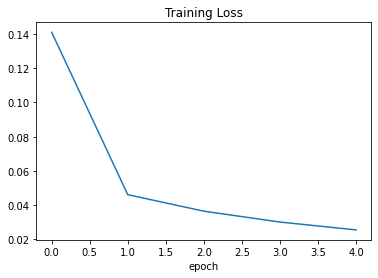

In [93]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [94]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # 모델을 평가모드로 설정 (dropout=False)

    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    # prediction에는 10개의 라벨에 대한 벡터 값들이 나타나있으므로 그 중 가장 큰 값 선택해야함
    # torch.argmax(prediction, 1)의 결과는 최댓값의 위치를 나타냄
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9788999557495117


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
